In [1]:
import pandas as pd

In [2]:
data = []

duration = "duration(ns/round)"
speedup = "speedup"
problem_size = "problem size"
template_dict = {
    "world size":0,
    "thread number":0,
    problem_size:0,
    "speed(px/s)":0.0,
    duration:0.0,
    "rounds":1,
}
filename=input("filename=")
prog = filename.split("-")[0]

In [3]:
if prog == "mpi":
    world_size = "world size"
elif prog == "hybrid":
    world_size = "thread number"
elif prog == "cuda":
    world_size = "threads per block"
else:
    world_size = "thread number"
with open(f"../logs/{filename}.log","r") as f:
    for line in f.readlines():
        if line.find(":") == -1:
            continue
        try:
            key,val = line.rstrip().split(":")
        except ValueError:
            display(line,key,val)
        val = val.lstrip()
        if key == world_size:
            data.append({})
        data[-1][key] = val
df = pd.DataFrame(data,dtype=float)
display(df[df.isna().any(axis=1)])
# df = df.dropna(axis=1)
df = df.convert_dtypes()
display(df.dtypes)
display(df.head())

,thread number,problem size,duration(ns/round),rounds


thread number         Int64
problem size          Int64
duration(ns/round)    Int64
rounds                Int64
dtype: object

,thread number,problem size,duration(ns/round),rounds
0,1,200,382628,1
1,1,1000,384819,1
2,1,5000,390498,1
3,1,10000,384242,1
4,2,200,264216,1


In [4]:
def get_one_core_duration(row,t1_df):
    t1 = t1_df.loc[t1_df[problem_size]==row[problem_size]][duration].values[0]
    return t1/row[duration]
t1_df = df[df[world_size]==1]
display(t1_df)
df[speedup] = df.apply(get_one_core_duration,args=(t1_df,),axis=1)
display(df.head())

,thread number,problem size,duration(ns/round),rounds
0,1,200,382628,1
1,1,1000,384819,1
2,1,5000,390498,1
3,1,10000,384242,1


,thread number,problem size,duration(ns/round),rounds,speedup
0,1,200,382628,1,1.000000
1,1,1000,384819,1,1.000000
2,1,5000,390498,1,1.000000
3,1,10000,384242,1,1.000000
4,2,200,264216,1,1.448164


In [5]:
tmp_df = df
if prog == "cuda":
    pass
elif prog == "mpi":
    tmp_df = df[df[world_size].isin(range(1,128,8))]
else:
    tmp_df = df[df[world_size].isin(range(1,32,3))]
tmp_df.set_index('problem size', inplace=True)

In [6]:
def show_and_save_overview_result(df,world_size,ylabel,title):
    plt = df.groupby(world_size)[ylabel].plot(legend=True,title=title,ylabel=ylabel)
    subplt = plt.iloc[0]
    fig = subplt.get_figure()
    filename = f"{prog}-{title}"
    filename = "".join(x for x in filename if x.isalnum())
    fig.savefig(filename)

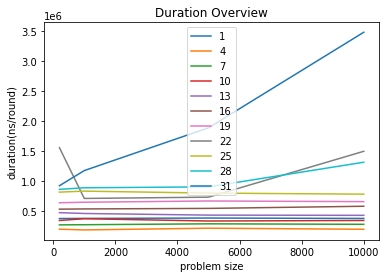

In [7]:
show_and_save_overview_result(tmp_df,world_size,duration,title="Duration Overview")

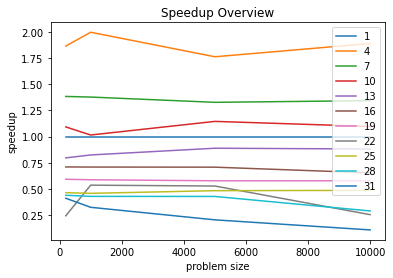

In [8]:
show_and_save_overview_result(tmp_df,world_size,speedup,title="Speedup Overview")

In [9]:
def show_and_save_groupby_result(groupby_key,xlable,ylabel):
    for input_size, group in df.groupby(groupby_key):
        title = f"{groupby_key} {int(input_size)}"
        subplt = group.plot(x=xlable,y=ylabel,title=title,ylabel=ylabel)
        fig = subplt.get_figure()
        filename = f"{prog}-{title}-{ylabel}"
        filename = "".join(x for x in filename if x.isalnum())
        fig.savefig(filename)

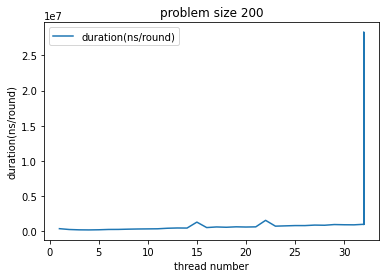

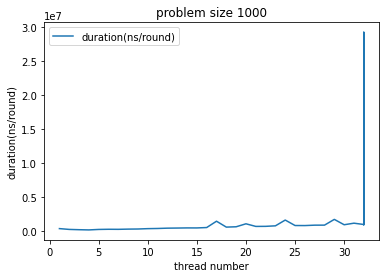

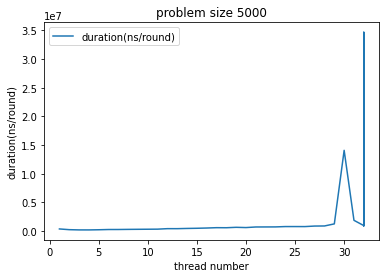

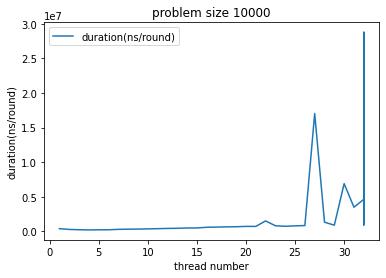

In [10]:
show_and_save_groupby_result(problem_size,xlable=world_size,ylabel=duration)

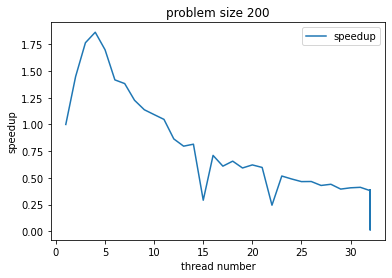

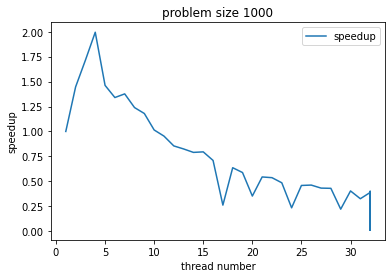

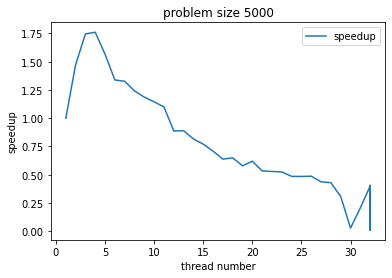

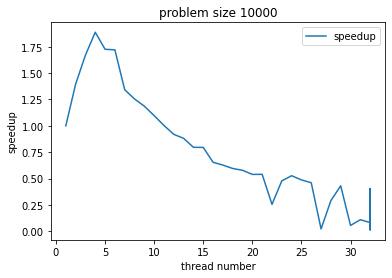

In [11]:
show_and_save_groupby_result(problem_size,xlable=world_size,ylabel=speedup)

In [12]:
# print(df.loc[lambda x:x[problem_size]==200].to_string())